In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

%matplotlib notebook

In [5]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(60, 10, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(120, 10, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(180, 10, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(240, 10, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(300, 10, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/5000.0]*5000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(x, fs) for x in d[6:9]] + [button])
    
    

In [6]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    en = np.array(np.where(xt == -1))[0]
    if len(st) > len(en):
        en = list(en)
        en.append(len(x[-1]) - 1)
        en = np.array(en)
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(3):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [7]:
files = ["f_down.txt", "f_rot.txt", "f_lat.txt"]
read_dat = [readFile(_) for _ in files]
feats = [extract_feat(_, feat) for _ in read_dat]

Reading: f_down.txt
Reading: f_rot.txt
Reading: f_lat.txt
42 42
40 40
47 47


In [8]:
for i in feats:
    print(len(i), i[0])

42 [535.53973833 570.39573155 391.08522968]
40 [325.2471812  139.81644477 104.41910068]
47 [154.58508514 125.31623019 148.90003472]


<IPython.core.display.Javascript object>


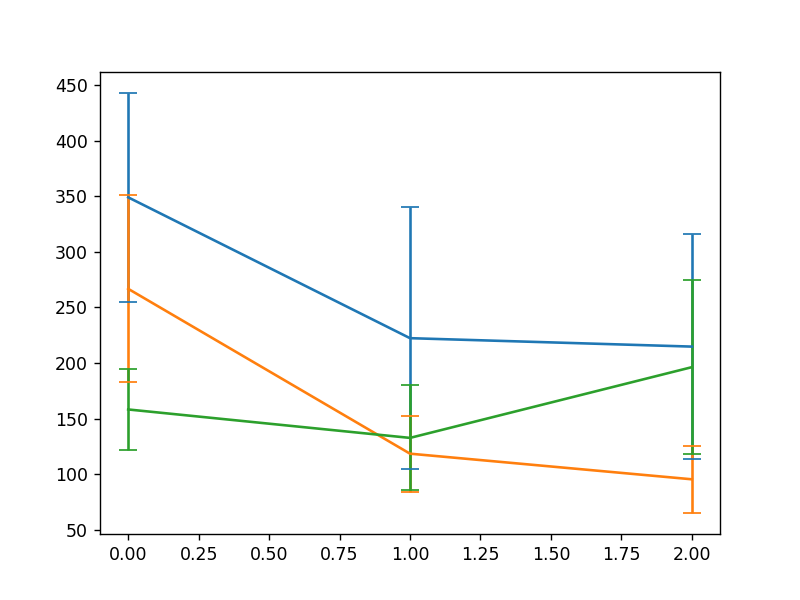

In [9]:
plt.figure()

colors = ["green", "red", "yellow", "blue", "orange"]

for ci,fe in enumerate(feats):
    fe = fe.swapaxes(0,1)
    #print(np.mean(fe, 1), np.std(fe, 1))
    plt.errorbar(range(3), np.mean(fe, 1), np.std(fe, 1), capsize=5)
    
    #for i in range(len(fe)):
    #    plt.plot(range(6), fe[i], "*", color = colors[ci])

plt.show()

In [10]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [11]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [12]:
dat = []
for chn in range(1, 4):
    tdat = []
    for chs in list(combinations([0,1,2], chn)):
        for chir in range(len(chs)):
            if len(chs) == 1: chir = None
            tdat.append([chs, chir, getAccuracy(*getXy(feats, chs, chir), r = 0.2)])
            print(tdat[-1])
    dat.append(tdat)

[(0,), None, (98.06990291262137, 52.692307692307686)]
[(1,), None, (88.24174757281554, 35.70384615384616)]
[(2,), None, (93.35631067961167, 36.55384615384616)]
[(0, 1), 0, (59.66213592233008, 56.71153846153846)]
[(0, 1), 1, (64.73106796116502, 62.49615384615385)]
[(0, 2), 0, (77.55436893203886, 76.38076923076922)]
[(0, 2), 1, (79.45145631067963, 78.78076923076922)]
[(1, 2), 0, (64.426213592233, 62.4)]
[(1, 2), 1, (63.55048543689318, 61.169230769230765)]
[(0, 1, 2), 0, (74.34271844660196, 72.51923076923077)]
[(0, 1, 2), 1, (77.72912621359224, 75.42692307692307)]
[(0, 1, 2), 2, (78.2611650485437, 77.30384615384615)]


In [13]:
Xx, Yy = [], []
M_X = []
for ci, i in enumerate(dat):
    MxX, MxV = None, None
    for j in i:
        Xx.append(ci+1)
        Yy.append(j[2][1])
        if MxV is None or MxV < j[2][1]:
            MxV = j[2][1]
            MxX = j
    M_X.append(MxX[2][1])
    print(MxX)
print(M_X)

[(0,), None, (98.06990291262137, 52.692307692307686)]
[(0, 2), 1, (79.45145631067963, 78.78076923076922)]
[(0, 1, 2), 2, (78.2611650485437, 77.30384615384615)]
[52.692307692307686, 78.78076923076922, 77.30384615384615]


In [14]:
M_X, Xx, Yy

([52.692307692307686, 78.78076923076922, 77.30384615384615],
 [1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3],
 [52.692307692307686,
  35.70384615384616,
  36.55384615384616,
  56.71153846153846,
  62.49615384615385,
  76.38076923076922,
  78.78076923076922,
  62.4,
  61.169230769230765,
  72.51923076923077,
  75.42692307692307,
  77.30384615384615])

In [1]:
M_X, Xx, Yy = ([52.692307692307686, 78.78076923076922, 77.30384615384615], [1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3], [52.692307692307686, 35.70384615384616, 36.55384615384616, 56.71153846153846, 62.49615384615385, 76.38076923076922, 78.78076923076922, 62.4, 61.169230769230765, 72.51923076923077, 75.42692307692307, 77.30384615384615])

<IPython.core.display.Javascript object>


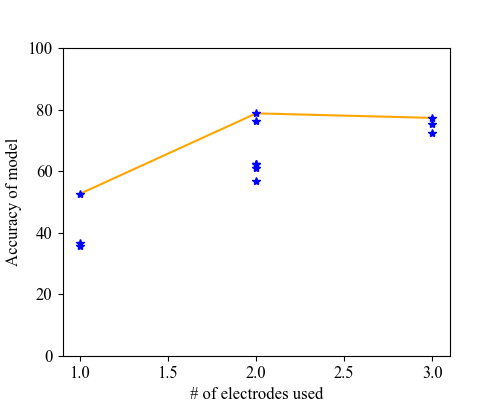

In [11]:
plt.figure(figsize=(5,4))
font = {'family' : 'Times New Roman ',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)
plt.plot(range(1,4), M_X, "-", color="orange")
plt.plot(Xx, Yy, "*", color="blue")
plt.xlabel("# of electrodes used")
plt.ylabel("Accuracy of model")
plt.ylim([0,100])
plt.show()

<IPython.core.display.Javascript object>


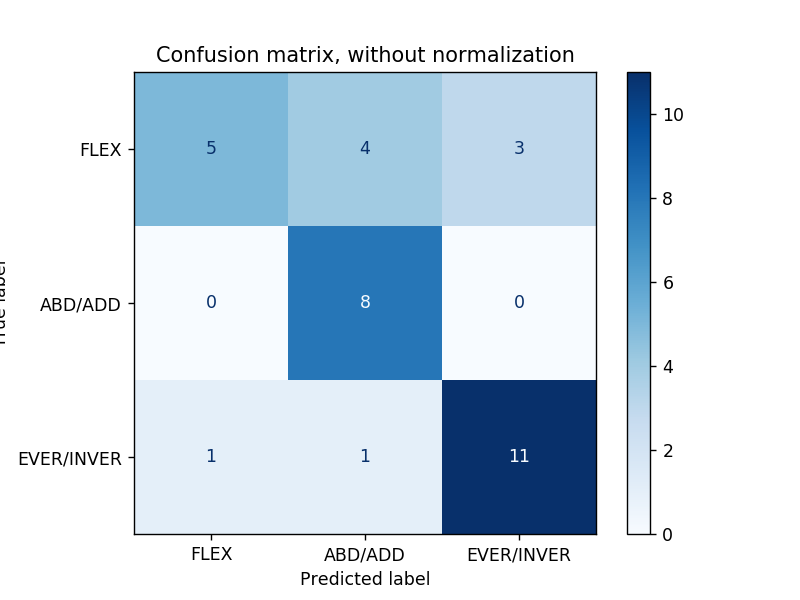

Confusion matrix, without normalization
[[ 5  4  3]
 [ 0  8  0]
 [ 1  1 11]]


<IPython.core.display.Javascript object>


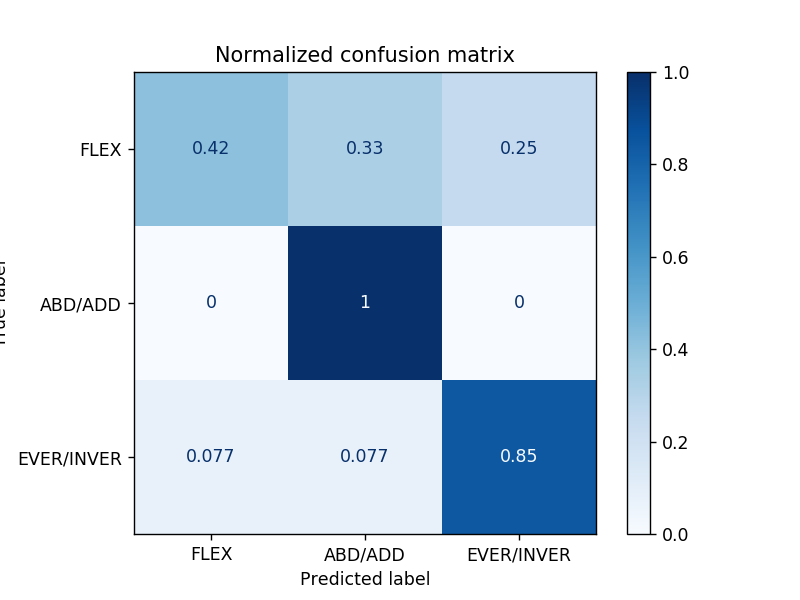

Normalized confusion matrix
[[0.42 0.33 0.25]
 [0.   1.   0.  ]
 [0.08 0.08 0.85]]


In [21]:

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
X, y = getXy(feats, [0,1,2], ratio_i = 1)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(gamma='auto').fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["FLEX", "ABD/ADD", "EVER/INVER"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
x, y = getXy(feats, [0,1,2], ratio_i = 0)
clf = SVC(gamma='auto')
y_pred = cross_val_predict(clf, x, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

[[15 19  8]
 [ 0 40  0]
 [ 6  3 38]]


<IPython.core.display.Javascript object>


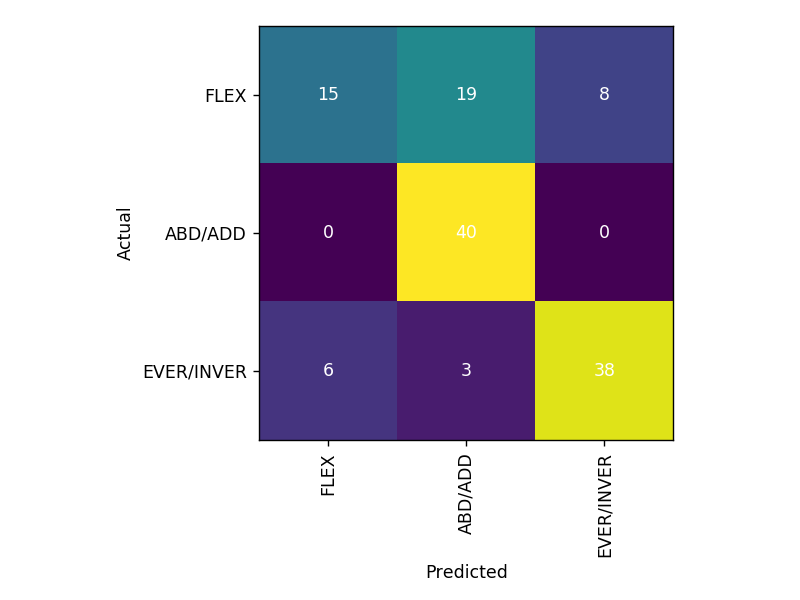

In [20]:
fig, ax = plt.subplots()

ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(["FLEX", "ABD/ADD", "EVER/INVER"])
ax.set_yticklabels(["FLEX", "ABD/ADD", "EVER/INVER"])
plt.xticks(rotation=90)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.title("Inter rotation training and testing")

res = np.array(conf_mat)
plt.tight_layout()
plt.imshow(res)
for i in range(3):
    for j in range(3):
        text = plt.text(j, i, res[i][j],ha="center", va="center", color="w")